In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

# import the necessary packages
from collections import OrderedDict
import numpy as np
import cv2


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])

FACIAL_LANDMARKS_5_IDXS = OrderedDict([
	("right_eye", (2, 3)),
	("left_eye", (0, 1)),
	("nose", (4))
])

FACIAL_LANDMARKS_IDXS = FACIAL_LANDMARKS_68_IDXS

def rect_to_bb(rect):
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
	coords = np.zeros((shape.num_parts, 2), dtype=dtype)
	for i in range(0, shape.num_parts):
		coords[i] = (shape.part(i).x, shape.part(i).y)

	return coords


def visualize_facial_landmarks(image, shape, colors=None, alpha=0.75):
	overlay = image.copy()
	output = image.copy()

	if colors is None:
		colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
			(168, 100, 168), (158, 163, 32),
			(163, 38, 32), (180, 42, 220), (0, 0, 255)]

	for (i, name) in enumerate(FACIAL_LANDMARKS_IDXS.keys()):
		(j, k) = FACIAL_LANDMARKS_IDXS[name]
		pts = shape[j:k]

		if name == "jaw":
			for l in range(1, len(pts)):
				ptA = tuple(pts[l - 1])
				ptB = tuple(pts[l])
				cv2.line(overlay, ptA, ptB, colors[i], 2)

		else:
			hull = cv2.convexHull(pts)
			cv2.drawContours(overlay, [hull], -1, colors[i], -1)

	cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

	return output

In [ ]:
class FaceAligner:
	def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
		desiredFaceWidth=256, desiredFaceHeight=None):
		self.predictor = predictor
		self.desiredLeftEye = desiredLeftEye
		self.desiredFaceWidth = desiredFaceWidth
		self.desiredFaceHeight = desiredFaceHeight

		if self.desiredFaceHeight is None:
			self.desiredFaceHeight = self.desiredFaceWidth

	def align(self, image, gray, rect):
		shape = self.predictor(gray, rect)
		shape = shape_to_np(shape)
		
		if (len(shape)==68):
			(lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
			(rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
		else:
			(lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
			(rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]
			
		leftEyePts = shape[lStart:lEnd]
		rightEyePts = shape[rStart:rEnd]

		leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
		rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

		dY = rightEyeCenter[1] - leftEyeCenter[1]
		dX = rightEyeCenter[0] - leftEyeCenter[0]
		angle = np.degrees(np.arctan2(dY, dX)) - 180

		desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

		dist = np.sqrt((dX ** 2) + (dY ** 2))
		desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
		desiredDist *= self.desiredFaceWidth
		scale = desiredDist / dist

		eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
			(leftEyeCenter[1] + rightEyeCenter[1]) // 2)

		M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

		tX = self.desiredFaceWidth * 0.5
		tY = self.desiredFaceHeight * self.desiredLeftEye[1]
		M[0, 2] += (tX - eyesCenter[0])
		M[1, 2] += (tY - eyesCenter[1])

		(w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
		output = cv2.warpAffine(image, M, (w, h),
			flags=cv2.INTER_CUBIC)

		return output

In [ ]:
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
from google.colab.patches import cv2_imshow

def shape_to_np(shape, dtype="int"):
	coords = np.zeros((68, 2), dtype=dtype)
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	return coords

def makeBox(family,person,filename,image,detector,predictor):
  image = imutils.resize(image, width=500)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 1)
  vis=False
  for (i, rect) in enumerate(rects):
    shape = face_utils.shape_to_np(predictor(gray, rect))
    
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cropped = image[y+2:y+h-2, x+2:x+w-2]
    vis=True

  if vis== True:    
    imgpath = str(family+person+'/Cropped_'+filename)
    cv2.imwrite(imgpath , cropped)
				
  return vis


In [ ]:
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_68_face_landmarks.dat"


--2021-12-02 21:25:29--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  42.5MB/s    in 1.4s    

2021-12-02 21:25:30 (42.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bunzip2: Output file /content/shape_predictor_68_face_landmarks.dat already exists.


In [ ]:
from imutils.face_utils import facealigner
from imutils.face_utils import rect_to_bb
import argparse
import imutils
import dlib
from google.colab.patches import cv2_imshow
import cv2
def face_extractor(family,person):
	img_base_path = family+person
	
	detector = dlib.get_frontal_face_detector()
	predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
	fa = FaceAligner(predictor, desiredFaceWidth=256)
	for filename in os.listdir(img_base_path):
		if filename.endswith("jpg"): 
	
			image = cv2.imread(img_base_path+'/'+ filename)
			image = imutils.resize(image, width=800)
			gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

			rects = detector(gray, 2)
			gen = False
			for rect in rects:
				faceAligned = fa.align(image, gray, rect)
				gen = makeBox(family,person,filename,faceAligned,detector,predictor)
				if gen == True:
					return True
	return False
				
		

In [ ]:
import os
def main():
  img_base_path = 'gdrive/My Drive/SponsoredProject/train-faces'
  dir = os.listdir(img_base_path)
  dir.sort()
  resume=False
  for family in dir:
    if os.path.isdir(img_base_path+'/'+family):
      # To avoid recomputation of image processing for already processed folders (i.e. till F0373)
      if family == 'F0373':
        resume=True
      if resume == False:
        print("Family skipped"+family)
        #print("conducting experiment 1 for AI project")
        continue
      print(family)
      for person in os.listdir(img_base_path+'/'+family):
        if os.path.isdir(img_base_path+'/'+family+'/'+person):
          try:
            face_extractor(img_base_path+'/'+family,'/'+person)
          except:
            print('FAIL AT:'+family)

main()

Family skippedF0001
Family skippedF0002
Family skippedF0004
Family skippedF0005
Family skippedF0009
Family skippedF0010
Family skippedF0011
Family skippedF0012
Family skippedF0013
Family skippedF0015
Family skippedF0016
Family skippedF0018
Family skippedF0020
Family skippedF0021
Family skippedF0023
Family skippedF0024
Family skippedF0029
Family skippedF0031
Family skippedF0032
Family skippedF0033
Family skippedF0035
Family skippedF0036
Family skippedF0038
Family skippedF0039
Family skippedF0042
Family skippedF0043
Family skippedF0045
Family skippedF0046
Family skippedF0047
Family skippedF0048
Family skippedF0050
Family skippedF0051
Family skippedF0052
Family skippedF0054
Family skippedF0058
Family skippedF0059
Family skippedF0061
Family skippedF0062
Family skippedF0064
Family skippedF0066
Family skippedF0067
Family skippedF0068
Family skippedF0069
Family skippedF0070
Family skippedF0073
Family skippedF0076
Family skippedF0077
Family skippedF0079
Family skippedF0080
Family skippedF0081


In [ ]:
!python example.py

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgGTV1amyan1jH_e4yPZcB5ZHFVtNHN89O1rA5J79PZJuFdPRe8orI
Mounted at /content/gdrive
usage: example.py [-h] -p SHAPE_PREDICTOR -i IMAGE
example.py: error: the following arguments are required: -p/--shape-predictor, -i/--image


In [ ]:
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2

In [ ]:
def rect_to_bb(rect):
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

In [ ]:
def shape_to_np(shape, dtype="int"):
	coords = np.zeros((68, 2), dtype=dtype)
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [ ]:
image = cv2.imread("alignedFace.jpg")
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)


In [ ]:
!pip install --upgrade imutils

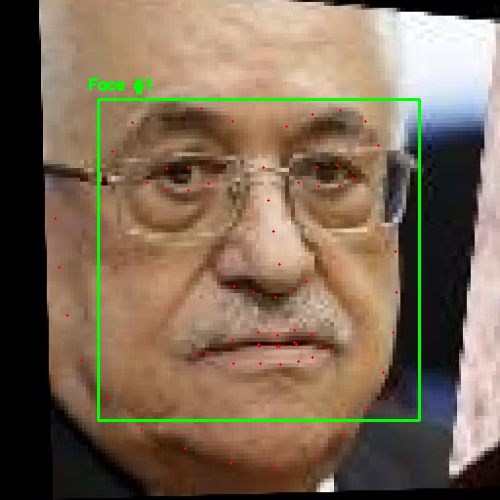

-1

In [ ]:
from google.colab.patches import cv2_imshow
for (i, rect) in enumerate(rects):
	shape = predictor(gray, rect)
	shape = face_utils.shape_to_np(shape)
  
	(x, y, w, h) = face_utils.rect_to_bb(rect)
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
	cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
	for (x, y) in shape:
    
		cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
cv2_imshow(image)
cv2.waitKey(0)

Left Eye points are : [[298 182]
 [317 167]
 [337 165]
 [352 178]
 [339 186]
 [318 186]]
Right Eye points are : [[147 182]
 [166 168]
 [188 167]
 [208 183]
 [188 190]
 [165 190]]
Mouth Eye points are : [[197 355]
 [232 340]
 [258 332]
 [277 335]
 [294 330]
 [311 335]
 [328 348]
 [312 357]
 [298 361]
 [280 364]
 [260 363]
 [233 363]
 [207 352]
 [258 344]
 [277 346]
 [294 342]
 [320 346]
 [296 344]
 [279 346]
 [259 346]]
Inner Mouth Eye points are : [[207 352]
 [258 344]
 [277 346]
 [294 342]
 [320 346]
 [296 344]
 [279 346]
 [259 346]]
Right Eyebrow points are : [[112 151]
 [132 122]
 [165 106]
 [201 108]
 [232 121]]
Left EyeBrow points are : [[286 126]
 [312 114]
 [340 110]
 [365 121]
 [378 145]]
Nose points are : [[263 167]
 [268 200]
 [273 231]
 [279 264]
 [234 286]
 [253 292]
 [275 297]
 [292 291]
 [306 281]]
Jaw points are : [[ 55 218]
 [ 59 267]
 [ 67 315]
 [ 81 360]
 [107 398]
 [141 429]
 [185 448]
 [230 463]
 [275 466]
 [316 458]
 [344 435]
 [367 407]
 [383 372]
 [393 332]
 [396

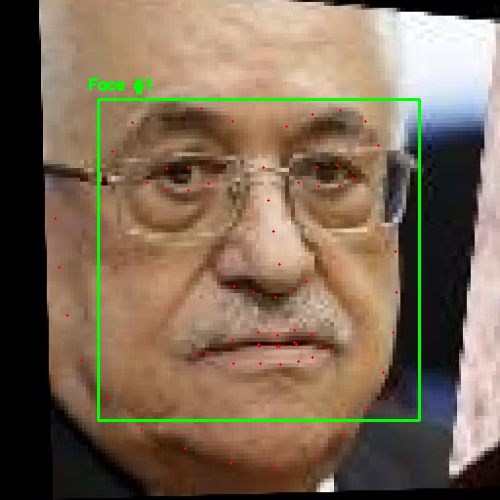

In [ ]:
from google.colab.patches import cv2_imshow
for (i, rect) in enumerate(rects):
  shape = predictor(gray, rect)
  shape = face_utils.shape_to_np(shape)
  #print(kinship)
  (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
  (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
  (mStart, mEnd) = FACIAL_LANDMARKS_68_IDXS["mouth"]
  (iMStart, iMEnd) = FACIAL_LANDMARKS_68_IDXS["inner_mouth"]
  (ryStart, ryEnd) = FACIAL_LANDMARKS_68_IDXS["right_eyebrow"]
  (lyStart, lyEnd) = FACIAL_LANDMARKS_68_IDXS["left_eyebrow"]
  (nStart, nEnd) = FACIAL_LANDMARKS_68_IDXS["nose"]
  (jStart, jEnd) = FACIAL_LANDMARKS_68_IDXS["jaw"]
  
  leftEyePts = shape[lStart:lEnd]
  rightEyePts = shape[rStart:rEnd]
  mouthPts = shape[mStart:mEnd]
  innerMouthPts = shape[iMStart:iMEnd]
  rightYBPts = shape[ryStart:ryEnd]
  leftYBPts = shape[lyStart:lyEnd]
  nosePts = shape[nStart:nEnd]
  jawPts = shape[jStart:jEnd]
  print("Left Eye points are : " + str(leftEyePts))
	
  print("Right Eye points are : " + str(rightEyePts))
  print("Mouth Eye points are : " + str(mouthPts))
  print("Inner Mouth Eye points are : " + str(innerMouthPts))
  print("Right Eyebrow points are : " + str(rightYBPts))
  print("Left EyeBrow points are : " + str(leftYBPts))
  print("Nose points are : " + str(nosePts))
  print("Jaw points are : " + str(jawPts))
  
  #FACIAL_LANDMARKS_68_IDXS["left_eye"]
  (x, y, w, h) = face_utils.rect_to_bb(rect)
  cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
  for (x, y) in shape:
    cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
cv2_imshow(image)
cv2.waitKey(0)
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])



  
